# 복잡한 object 구별하기 (강이지 vs 고양이) : from Deep learning with Python 

## 아래 코드는 "케라스 창시자에게 배우는 딥러닝"의  역자 Github (https://github.com/rickiepark/deep-learning-with-python-notebooks) 에서 받은 소스파일을 교육목적으로 재구성함

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # The kernel appears to have died. It will restart automatically 문제 수정

In [2]:
import keras
keras.__version__

import os, shutil # 파일 연산을 위한 라이브러리 

## 파이썬 기능을 사용하여, 파일 분류 
이 주피터 노트북이 있는 폴더에 데이터 zip 을 압축 해제 하기 바랍니다.

In [3]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로 
original_dataset_dir = './datasets/cats_and_dogs/train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = './datasets/cats_and_dogs_small'

if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [4]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


## 데이터 전처리 

데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 합니다. 지금은 데이터가 JPEG 파일로 되어 있으므로 네트워크에 주입하려면 대략 다음 과정을 따릅니다.

1.	사진 파일을 읽습니다.
2.	JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
3.	그다음 부동 소수 타입의 텐서로 변환합니다.
4.	픽셀 값(0에서 255 사이)의 스케일을 [0, 1] 사이로 조정합니다(신경망은 작은 입력 값을 선호합니다).

좀 복잡하게 보일 수 있지만 다행히 케라스는 이런 단계를 자동으로 처리하는 유틸리티를 가지고 있습니다. 케라스는 `keras.preprocessing.image`에 이미지 처리를 위한 헬퍼 도구들을 가지고 있습니다. 특히 `ImageDataGenerator` 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어주는 파이썬 제너레이터를 만들어 줍니다. 이 클래스를 사용해 보겠습니다.

In [5]:
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
with tf.device('/gpu:0'):
    # 모든 이미지를 1/255로 스케일을 조정합니다
    train_datagen = ImageDataGenerator(rescale = 1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            # 타깃 디렉터리
            train_dir,
            # 모든 이미지를 150 × 150 크기로 바꿉니다
            target_size=(150, 150),
            batch_size=20,
            # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다 (강아지 vs 고양이)
            class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150),
            batch_size=20,
            class_mode='binary')

2021-12-13 20:51:16.049673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 20:51:16.068704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 20:51:16.069236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 20:51:16.070571: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


In [7]:
from keras import layers
from keras import models

with tf.device('/gpu:0'):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [8]:
with tf.device('/gpu:0'):
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [9]:
# history= model.fit(train_images,train_labels,epochs=20, batch_size=100, verbose=2,validation_data=(test_images, test_labels))
with tf.device('/gpu:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=100,  
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50
    )

Epoch 1/30


2021-12-13 20:51:18.073826: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


100/100 [==============================] - 8s 54ms/step - loss: 0.6997 - accuracy: 0.4940 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/30
100/100 [==============================] - 5s 53ms/step - loss: 0.6848 - accuracy: 0.5180 - val_loss: 0.6850 - val_accuracy: 0.5930
Epoch 3/30
100/100 [==============================] - 5s 51ms/step - loss: 0.6598 - accuracy: 0.5945 - val_loss: 0.6584 - val_accuracy: 0.5270
Epoch 4/30
100/100 [==============================] - 5s 51ms/step - loss: 0.6516 - accuracy: 0.6020 - val_loss: 0.6448 - val_accuracy: 0.6340
Epoch 5/30
100/100 [==============================] - 5s 51ms/step - loss: 0.6136 - accuracy: 0.6630 - val_loss: 0.5891 - val_accuracy: 0.6830
Epoch 6/30
100/100 [==============================] - 5s 52ms/step - loss: 0.5764 - accuracy: 0.7020 - val_loss: 0.5769 - val_accuracy: 0.6960
Epoch 7/30
100/100 [==============================] - 5s 51ms/step - loss: 0.5367 - accuracy: 0.7340 - val_loss: 0.5782 - val_accuracy: 0.6890
Epoch 8/30

In [10]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

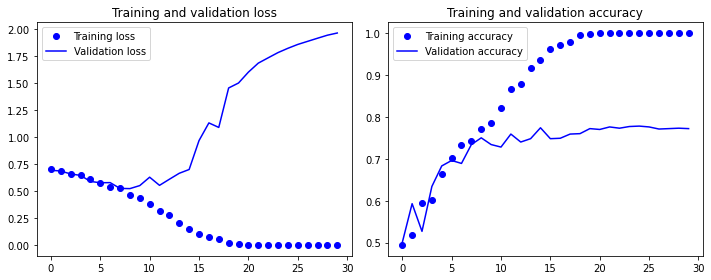

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Question: 


<img src="overfitting.png" width="70%">

현재 테스트에서 overfitting이 일어나고 있습니다.
수업 시간에 배웠던 다양한 방법을 통해 overfitting을 최소화 시키고, 결과를 위와 같이 그래프로 표시하세요. 
결과값이 나타낸 대로 저장을 하여 제출하시기 바랍니다.  

In [12]:
from keras.preprocessing.image import ImageDataGenerator
with tf.device('/gpu:0'):
    # 모든 이미지를 1/255로 스케일을 조정합니다
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                       #samplewise_std_normalization=True,
                                       shear_range = 0.2,#data augmentation을 통해 data 수를 늘린다(data의 질은 좋지 못함)=>overfitting 방지
                                       zoom_range = 0.2,
                                       rotation_range = 30,
                                       #brightness_range=(0.8,1.2),
                                       horizontal_flip = True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            # 타깃 디렉터리
            train_dir,
            # 모든 이미지를 150 × 150 크기로 바꿉니다
            target_size=(150, 150),
            batch_size=20,
            # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다 (강아지 vs 고양이)
            class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150),
            batch_size=20,
            class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
from keras import layers
from keras import models
from keras import regularizers
from keras.layers import BatchNormalization, Dropout, Activation

#https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
with tf.device('/gpu:0'):
    model = models.Sequential()#모델을 간단화(학습해야 할 파라미터 수를 줄임)=>복잡함으로 인한 overfitting 방지

    model.add(layers.Conv2D(32, (3, 3),input_shape=(150, 150, 3),kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.001)))#regulization(0에 가까운 가중치는 0으로 & 가중치 값이 너무 크지 않도록)을 통한 overfitting 방지
    model.add(BatchNormalization())#batch normalization을 통한 overfitting 방지(regularize효과)
    model.add(Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3),kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3),kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3),kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(512,kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))#drop out을 통한 overfitting 방지(robust한 모델, 특정 data에 과하게 학습되지 않도록)
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    #https://link.springer.com/article/10.1007/s11042-019-08453-9의 자료를 참고하여 CNN에서는 dropout을 사용하지 않았다.
    #일부 자료에서는 dropout과 batch normalization이 같은 효과를 가진다고 주장하는데 그 이유를 잘 모르겠어서 둘다 사용했습니다.
    #l1,l2 regularize을 쓰지 않으면 val loss가 증가하는(국소적으로 증가하는 것이 아닌) 현상이 발생해서 사용하였습니다.(데이터가 적어 더욱 강한 규제 적용)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 72, 72, 64)      

In [16]:
# history= model.fit(train_images,train_labels,epochs=20, batch_size=100, verbose=2,validation_data=(test_images, test_labels))
with tf.device('/gpu:0'):

    cp_callback = keras.callbacks.ModelCheckpoint(filepath='model.h5',save_best_only=True ,verbose=1) #best acc model 저장


    history = model.fit(
        train_generator,
        steps_per_epoch=100,  
        epochs=100,#여러 규제들을 적용하여 학습 속도가 느려짐=>epoch을 늘려 더 오래 학습시킴, 실제로는 50 epoch이 넘어가면 점점 overfitting이 되지만 val_acc이 안정되어서 다음과 같이 했다. 순간적인 acc만 볼 것이면 50이어도 충분하다.
        validation_data=validation_generator,
        callbacks=[cp_callback],
        validation_steps=50
    )


Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.2144 - accuracy: 0.5740
Epoch 00001: val_loss improved from inf to 4.69788, saving model to model.h5
100/100 [==============================] - 11s 98ms/step - loss: 5.2144 - accuracy: 0.5740 - val_loss: 4.6979 - val_accuracy: 0.5000
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 3.7669 - accuracy: 0.6515
Epoch 00002: val_loss improved from 4.69788 to 3.42143, saving model to model.h5
100/100 [==============================] - 10s 100ms/step - loss: 3.7669 - accuracy: 0.6515 - val_loss: 3.4214 - val_accuracy: 0.5000
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 2.8639 - accuracy: 0.6770
Epoch 00003: val_loss improved from 3.42143 to 2.69673, saving model to model.h5
100/100 [==============================] - 10s 100ms/step - loss: 2.8639 - accuracy: 0.6770 - val_loss: 2.6967 - val_accuracy: 0.5040
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss

Epoch 29/100
100/100 [==============================] - ETA: 0s - loss: 0.9319 - accuracy: 0.7690
Epoch 00029: val_loss improved from 0.92330 to 0.92123, saving model to model.h5
100/100 [==============================] - 10s 100ms/step - loss: 0.9319 - accuracy: 0.7690 - val_loss: 0.9212 - val_accuracy: 0.7820
Epoch 30/100
100/100 [==============================] - ETA: 0s - loss: 0.9378 - accuracy: 0.7565
Epoch 00030: val_loss did not improve from 0.92123
100/100 [==============================] - 10s 101ms/step - loss: 0.9378 - accuracy: 0.7565 - val_loss: 1.0668 - val_accuracy: 0.7140
Epoch 31/100
100/100 [==============================] - ETA: 0s - loss: 0.9588 - accuracy: 0.7510
Epoch 00031: val_loss improved from 0.92123 to 0.88810, saving model to model.h5
100/100 [==============================] - 10s 100ms/step - loss: 0.9588 - accuracy: 0.7510 - val_loss: 0.8881 - val_accuracy: 0.7780
Epoch 32/100
100/100 [==============================] - ETA: 0s - loss: 0.9118 - accuracy: 

100/100 [==============================] - ETA: 0s - loss: 0.7710 - accuracy: 0.8030
Epoch 00057: val_loss did not improve from 0.76105
100/100 [==============================] - 10s 102ms/step - loss: 0.7710 - accuracy: 0.8030 - val_loss: 1.0586 - val_accuracy: 0.6690
Epoch 58/100
100/100 [==============================] - ETA: 0s - loss: 0.7542 - accuracy: 0.8015
Epoch 00058: val_loss did not improve from 0.76105
100/100 [==============================] - 10s 101ms/step - loss: 0.7542 - accuracy: 0.8015 - val_loss: 0.7724 - val_accuracy: 0.7910
Epoch 59/100
100/100 [==============================] - ETA: 0s - loss: 0.7552 - accuracy: 0.8015
Epoch 00059: val_loss did not improve from 0.76105
100/100 [==============================] - 10s 96ms/step - loss: 0.7552 - accuracy: 0.8015 - val_loss: 0.8615 - val_accuracy: 0.7330
Epoch 60/100
100/100 [==============================] - ETA: 0s - loss: 0.7507 - accuracy: 0.8035
Epoch 00060: val_loss improved from 0.76105 to 0.73520, saving mode

100/100 [==============================] - ETA: 0s - loss: 0.6468 - accuracy: 0.8220
Epoch 00085: val_loss did not improve from 0.64533
100/100 [==============================] - 10s 97ms/step - loss: 0.6468 - accuracy: 0.8220 - val_loss: 0.7702 - val_accuracy: 0.7730
Epoch 86/100
100/100 [==============================] - ETA: 0s - loss: 0.6296 - accuracy: 0.8300
Epoch 00086: val_loss did not improve from 0.64533
100/100 [==============================] - 10s 100ms/step - loss: 0.6296 - accuracy: 0.8300 - val_loss: 0.7035 - val_accuracy: 0.7870
Epoch 87/100
100/100 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.8180
Epoch 00087: val_loss did not improve from 0.64533
100/100 [==============================] - 10s 99ms/step - loss: 0.6704 - accuracy: 0.8180 - val_loss: 0.6747 - val_accuracy: 0.8170
Epoch 88/100
100/100 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.8415
Epoch 00088: val_loss did not improve from 0.64533
100/100 [========

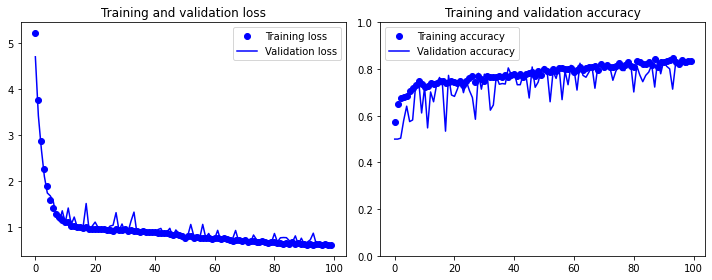

In [17]:
history.history.keys()
model.save('CatsDogs.h5')

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))



plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.subplot(122)
plt.ylim([0.0, 1.0]) 
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.tight_layout()
plt.show()
#https://stats.stackexchange.com/questions/255105/why-is-the-validation-accuracy-fluctuating
#에 의하면 data가 충분하지 못해서 fluctuating이 발생하는 것 같다. 개인적인 의견으로 운이 좋게 validation dataset에 알맞게 train이 된 것으로 보인다.
#조금 더 넓은 폭의 data에 대해서라면 epoch을 늘린 모델이 적합할 것으로 보인다(epoch이 늘어날 수록 fluctuating이 줄어듬)

#dataset 이미지를 확인해보았는데 고양이가 여러마리 있거나 물체에 가려져있거나 사람과 같이 있거나, 글씨가 있는 등 여러 경우가 있다.(좋지 못한 dataset,고양이와 개만 있는 데이터가 아님)
#이러한 dataset에 대해 cat dog로 구분하기에는 힘들어 보이고 실제로도 그렇다. RCNN처럼 selective search(혹은 전처리:원래 되어 있어야 하는)를 한 후 classify를 하면 더 좋은 성능의 모델을 얻을 수 있을 것 같다.

In [18]:
import numpy as np
print(f"best training loss:{np.min(loss):.4f}\nbest validation loss:{np.min(val_loss):.4f}\n")
print(f"best training accuracy:{np.max(acc):.4f}\nbest validation accuracy:{np.max(val_acc):.4f}")

best training loss:0.6066
best validation loss:0.6175

best training accuracy:0.8460
best validation accuracy:0.8440


In [19]:
from keras.models import load_model

best_model = load_model('model.h5')


In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

results = best_model.evaluate(test_datagen)
print(f"test loss:{results[0]:.3f}, test acc:{results[1]:.3f}")

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 2s 34ms/step - loss: 0.6835 - accuracy: 0.7990
test loss:0.684, test acc:0.799


# 평가

<p>주어진 모델은 최대 val_acc가 0.7330, 설계한 모델은 최대 val_acc가 0.8720으로 성능 향상이 있었다.</p> 

> 여러번 실험해본 결과 데이터가 어떻게 split되느냐에 따라 전체적인 acc 평균이 크게 달라진다.(acc_2 = acc_1 +(-0.05~0.05))

<br>
<p>plot을 보면 주어진 모델은 val_loss가 epoch가 10일 때부터 증가함수 형태를 띄어 overfitting이 발생했음을 알 수 있다. 반면 설계한 모델은 val_loss에서 fluctuation이 발생하지만 주석에서 설명했듯이 강한 규제에 데이터 수가 적어 특정학습에서 우연히 좋게 평가되거나 나쁘게 평가되어 발생하는 문제로 보인다. 물론 epoch이 50이 넘어가면서 overfitting이 생기지만 주어진 모델보다 약하다.</p>
<br>
<p>주석에서 설명했듯 설계한 모델은 아래와 같은 방법을 통해 overfitting을 방지했다.</p>

  * 1. 모델을 간략화하여 가중치 수를 줄였다.
  * 2. l1,l2 regularization을 통해 가중치 크기를 줄였다.
  * 3. batch normalization을 사용하였다.
  * 4. dropout을 사용하였다.
  * 5. data augmentation을 사용하였다.

  > 자세한 내용 및 참고 자료는 주석부분 참고

<p>val_loss가 가장 낮은 모델로 test한 결과 0.8480의 acc를 얻을 수 있었다.</p>